In [33]:
import os
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from presidio_analyzer import AnalyzerEngine, PatternRecognizer, Pattern
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import LatentDirichletAllocation
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from interpret.glassbox import ExplainableBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
plot_path = f'./temp/in_sample/plots'
tables_path = f'./temp/in_sample/tables'

In [40]:
transcript = pd.read_csv('transcripts/transcripts.csv', delimiter='|')
qna =  pd.read_csv('transcripts/QnA.csv', delimiter='|')

# Merge the two dataframes
df = pd.merge(transcript, qna[['transcript','filename']], on='filename')

# Combine the transcript and QnA columns
df['transcript'] = df['transcript_x'] + ' ' + df['transcript_y']

# Drop the old columns
df.drop(columns = ['transcript_x', 'transcript_y'], inplace = True)

In [41]:
df.head()

,filename,Company,Quarter,Year,Date,transcript
0,"Alion Science and Technology Corp., Q4 2011 Ea...",Alion Science and Technology Corp.,Q4,2011.0,"Dec 21, 2011","Presentation\nOperator\nGood day, ladies and g..."
1,"Allison Transmission Holdings, Inc., Q1 2014 E...","Allison Transmission Holdings, Inc.",Q1,2014.0,"Apr 17, 2014","Presentation\nOperator\nGood morning, ladies a..."
2,"Affinity Gaming, Q3 2013 Earnings Call, Nov 13...",Affinity Gaming,Q3,2013.0,"Nov 13, 2013","Presentation\nOperator\nGreetings, and welcome..."
3,"Alion Science and Technology Corp., Q4 2013 Ea...",Alion Science and Technology Corp.,Q4,2013.0,"Jan 08, 2014","Presentation\nOperator\nGood day, ladies and g..."
4,"Ameren Corporation, Q1 2011 Earnings Call, May...",Ameren Corporation,Q1,2011.0,"May 05, 2011",Presentation\nOperator\nGood morning ladies an...


In [42]:
mapping = pd.read_csv('data/mapping.csv')

# create a new column 'AllNames' that concatenates all versions of 'Company' for a 'CompanyName'
mapping['AllNames'] = mapping.groupby('RR_CompanyName')['Transcript_Mapping'].transform(lambda x: ', '.join(x))
mapping.head()

,RR_CompanyName,Transcript_Mapping,AllNames
0,"1-800-FLOWERS.COM, Inc.",1-800-Flowers.com Inc.,1-800-Flowers.com Inc.
1,3M Company,3M Company,"3M Company, 3M Co."
2,3M Company,3M Co.,"3M Company, 3M Co."
3,A.M. Castle & Co.,A. M. Castle Co.,"A. M. Castle Co., A.M. Castle Co., AM Castle..."
4,A.M. Castle & Co.,A.M. Castle Co.,"A. M. Castle Co., A.M. Castle Co., AM Castle..."


In [43]:
# Load recovery rates
rr = pd.read_csv('data/RR_Bonds.csv')
rr = rr[['Ddate', 'RR', 'CompanyName', 'CUSIP', 'LTDIssuance2', 'Intangibility', 'Receivables1']]

preprocessed_df = pd.read_csv('data/preprocessed_bond_data.csv')

# Add rr columns to preprocessed_df on index
preprocessed_df['RR'] = rr['RR']
preprocessed_df['Ddate'] = rr['Ddate']
preprocessed_df['CompanyName'] = rr['CompanyName']
preprocessed_df['CUSIP'] = rr['CUSIP']
preprocessed_df['LTDIssuance2'] = rr['LTDIssuance2']
preprocessed_df['Intangibility'] = rr['Intangibility']
preprocessed_df['Receivables1'] = rr['Receivables1']

rr = preprocessed_df

# Convert 'Date' column to datetime
rr['Ddate'] = pd.to_datetime(rr['Ddate'], errors='coerce')
rr.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,Russell 2000 Price Index return,Russell 2000 Vol 1m,Wilshire US Small-Cap Price Index,Wilshire Small Cap Vol,Ddate,CompanyName,CUSIP,LTDIssuance2,Intangibility,Receivables1
0,0.189010,0,0,0,1,0,0,1.28712,0.258205,-0.776257,...,0.01903,21.04,3056.03,808.357714,2004-01-01,Bethlehem Steel Corp.,087509AL9,0.467834468,0.058009127,0.029416454
1,20.553472,0,1,0,1,0,0,-135.21500,1.269706,-0.564199,...,0.01903,21.04,3137.10,974.749210,2004-05-01,"T-Mobile US, Inc.",45071TAD7,0,0.200428895,0.032214499
2,54.315958,0,1,0,1,0,0,-366.57500,1.081883,-0.671751,...,0.01903,21.05,3178.04,825.987663,2004-01-15,RCN Corporation,749361AC5,0,0.005146611,0.032214499
3,54.798870,0,1,0,1,0,0,-366.57500,1.081883,-0.671751,...,0.01903,21.05,3178.04,825.987663,2004-01-15,RCN Corporation,749361AD3,0,0.005146611,0.029416454
4,56.666288,0,1,0,1,0,0,-366.57500,1.081883,-0.671751,...,0.01903,21.05,3178.04,825.987663,2004-01-15,RCN Corporation,749361AG6,0,0.005146611,0.029416454


In [44]:
len(rr)

2636

In [45]:
# merge rr with mapping on CompanyName and RR_CompanyName
rr = rr.merge(mapping, left_on='CompanyName', right_on='RR_CompanyName')

In [46]:
# join with df on Company and Transcripts_Mapping
merged_df = rr.merge(df, left_on='Transcript_Mapping', right_on='Company')
print(merged_df['CompanyName'].value_counts())

Ally Financial Inc.               10317
CIT Group Inc.                    10185
Lehman Brothers Holdings, Inc.     2853
Charter Communications, Inc.       2144
Sempra Energy                      1147
                                  ...  
Frontier Group Holdings, Inc.         1
Dayton Superior Corporation           1
Franklin Bank Corp.                   1
Kellwood Company, LLC                 1
Turning Point Brands, Inc.            1
Name: CompanyName, Length: 210, dtype: int64


In [47]:
# Ensure the columns are in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Ddate'] = pd.to_datetime(merged_df['Ddate'])

In [48]:
merged_df = merged_df[merged_df['Ddate']>merged_df['Date']]
merged_df = merged_df.sort_values(by='Date').groupby(['CUSIP']).tail(1)

print(merged_df['CompanyName'].value_counts())

Lehman Brothers Holdings, Inc.      317
CIT Group Inc.                      291
Charter Communications, Inc.         28
Ford Motor Company                   19
iStar Inc.                           17
                                   ... 
Centrus Energy Corp.                  1
Education Management Corporation      1
Venoco, Inc.                          1
Exelon Corporation                    1
Kellwood Company, LLC                 1
Name: CompanyName, Length: 159, dtype: int64


In [49]:
# Compute the difference in days
merged_df['diff'] = (merged_df['Ddate'] - merged_df['Date']).dt.days


In [50]:
# Initialize stemmer
stemmer = SnowballStemmer("english")

# Keywords for each credit factor
credit_keywords = {
    'Profitability': ['revenue', 'cost', 'profit', 'earnings', 'margins', 'performance', 'income', 'loss', 'decline', 'decrease', 'outlook', 'guidance'],
    'Liquidity': ['cash', 'liquidity', 'credit', 'flow', 'operations', 'expenditures', 'free cash', 'working capital', 'insolvency', 'crunch', 'flexibility', 'funding'],
    'Leverage': ['debt', 'leverage', 'refinancing', 'reduction', 'interest', 'coverage', 'repayments', 'compliance', 'rating', 'default', 'restructuring'],
    'Operating': ['sales', 'market share', 'efficiency', 'cost', 'position', 'conditions', 'production', 'challenges', 'decline', 'improvement'],
    'Market': ['stock', 'market', 'investor', 'volatility', 'shareholder', 'confidence', 'buybacks', 'dilution', 'perception'],
    'Management': ['management', 'strategic', 'restructuring', 'strategy', 'adaptability', 'leadership', 'initiatives', 'governance', 'organizational', 'CEO', 'board']
}

# Function to identify sections with potential bankruptcy indicators
def identify_bankruptcy_indicators(transcript, keywords):
    sentences = nltk.sent_tokenize(transcript)
    indicator_sentences = []
    for sentence in sentences:
        for key in keywords:
            if any(re.search(r'\b' + re.escape(word) + r'\b', sentence, re.IGNORECASE) for word in keywords[key]):
                indicator_sentences.append(sentence)
                break

    return ' '.join(indicator_sentences)

# Function to clean text by stemming and replacing numbers with magnitude tokens
def clean_text(text):
    # Replace numbers with tokens
    text = re.sub(r'\b\d+(\.\d+)?\s?(billion|bln)\b', 'bln', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d+(\.\d+)?\s?(million|mln)\b', 'mln', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d{1,3}(,\d{3})*(\.\d+)?\b', 'num', text)  # Replace remaining numbers with 'num'
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize, stem, and rejoin
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words if len(word) > 1]  # Remove single characters that might be noise
    return ' '.join(stemmed_words)

# Transform transcript to lowercase
merged_df['transcript'] = merged_df['transcript'].str.lower()

# Apply function to identify bankruptcy indicators
merged_df['Bankruptcy_Indicators'] = merged_df['transcript'].apply(lambda x: identify_bankruptcy_indicators(x, credit_keywords))

# Apply function to clean text
merged_df['Cleaned_Bankruptcy_Indicators'] = merged_df['Bankruptcy_Indicators'].apply(clean_text)

# reset index
merged_df.reset_index(drop=True, inplace=True)

In [51]:
# export to csv
merged_df.to_csv('transcripts/mapped_transcripts.csv', index=False, sep='|')

In [52]:
sentiment = pd.read_csv('data/sentiment.csv')

# drop all columns except Word, Negative, Positive, Uncertainty, Litigious, Strong_Modal, Weak_Modal
sentiment = sentiment[['Word', 'Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal']]

# change any number in Negative, Positive, Uncertainty, Litigious, Strong_Modal, Weak_Modal to 1
sentiment.loc[sentiment['Negative'] != 0, 'Negative'] = 1
sentiment.loc[sentiment['Positive'] != 0, 'Positive'] = 1
sentiment.loc[sentiment['Uncertainty'] != 0, 'Uncertainty'] = 1
sentiment.loc[sentiment['Litigious'] != 0, 'Litigious'] = 1
sentiment.loc[sentiment['StrongModal'] != 0, 'StrongModal'] = 1
sentiment.loc[sentiment['WeakModal'] != 0, 'WeakModal'] = 1

# drop all rows where all columns are 0
sentiment = sentiment[(sentiment[['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal']] != 0).any(axis=1)]

sentiment.head()

,Word,Negative,Positive,Uncertainty,Litigious,StrongModal,WeakModal
9,ABANDON,1,0,0,0,0,0
10,ABANDONED,1,0,0,0,0,0
11,ABANDONING,1,0,0,0,0,0
12,ABANDONMENT,1,0,0,0,0,0
13,ABANDONMENTS,1,0,0,0,0,0


In [53]:
credit_sentiment = pd.read_excel('data/credit_keywords.xlsx')
# concate sentiment and credit_sintiment
sentiment = pd.concat([sentiment, credit_sentiment], ignore_index=True)

# make all words in Word column lowercase and stem them
sentiment['Word'] = sentiment['Word'].str.lower()
sentiment['Word'] = sentiment['Word'].apply(lambda x: stemmer.stem(x))

# drop duplicates
sentiment.drop_duplicates(subset='Word', keep='first', inplace=True)

In [54]:
# in lower case
financial_lexicon = sentiment['Word'].tolist()

def filter_tokens_by_lexicon(text, lexicon):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word in lexicon]
    return ' '.join(filtered_tokens)

filtered_transcripts = [filter_tokens_by_lexicon(transcript, financial_lexicon) for transcript in merged_df['Cleaned_Bankruptcy_Indicators']]

# Build the DTM
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(filtered_transcripts)
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

In [55]:
# Filter the DTM to include only relevant credit keywords bigrams
filtered_columns = [col for col in dtm_df.columns if any(kw in col for sublist in credit_keywords.values() for kw in sublist)]
filtered_dtm_df = dtm_df[filtered_columns]

# Display the filtered DTM
print(filtered_dtm_df)

      board  cash  cost  credit  crunch  debt  default  flow  interest  \
0         1     7     5       0       0     4        0     5         5   
1         2     9    10       2       0     2        0     5         7   
2         1    36    30       5       0     6        1     2         2   
3         5     0    37       8       0     4        0     1         0   
4         1    30    25       7       0     6        0    14         5   
...     ...   ...   ...     ...     ...   ...      ...   ...       ...   
1070      5     1    11      17       0     3        0    12         3   
1071      5     1    11      17       0     3        0    12         3   
1072      0     8    26       3       0     2        0     0         1   
1073      0     2     5       1       0     1        0     6         1   
1074      0     2     5       1       0     1        0     6         1   

      investor  leadership  loss  market  outlook  profit  redefault  stock  \
0            2           1     0

In [56]:
# Combine LDA topic distributions with TFIDF and LOG1P features

# Compute TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(filtered_transcripts)
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Compute LOG1P
log1p_df = np.log1p(dtm_df)

# Adding log volatility as an additional feature (using placeholder values for volatility)
log_volatility = np.log(np.random.rand(len(merged_df)) + 1)  # Placeholder for actual volatility data

In [57]:
# Perform Topic Modeling
num_topics = 3  # Define the number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(filtered_dtm_df)

# Get the words (terms) from the Document-Term Matrix (DTM)
words = filtered_dtm_df.columns  # Assuming dtm is a DataFrame, otherwise use the vectorizer's .get_feature_names_out() method

# Get the top words for each topic
num_top_words = 5  # Number of top words to display per topic

# Loop through each topic and get the top words
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[-num_top_words:][::-1]  # Get indices of top words in the topic
    top_words = [words[i] for i in top_words_idx]  # Get the actual words
    top_words_weights = topic[top_words_idx]  # Get the weights of the top words
    print("Top words:", top_words)
    print("Weights:", top_words_weights)
    print("\n")

Topic 1:
Top words: ['market', 'credit', 'loss', 'cash', 'cost']
Weights: [19979.42149927 17297.46488016  5545.28303709  3401.34471432
  3159.2104381 ]


Topic 2:
Top words: ['market', 'cost', 'cash', 'flow', 'interest']
Weights: [10117.00449894  7684.63551717  6556.20309793  2258.77564757
  1883.5040212 ]


Topic 3:
Top words: ['market', 'debt', 'loss', 'cash', 'flow']
Weights: [21378.57400179 10361.60513078  5793.29725427  5337.45218775
  4239.72595905]




In [58]:
# transfrom the lda_topics to a DataFrame
lda_topics_df = pd.DataFrame(lda_topics, columns=[f"Topic {i+1}" for i in range(num_topics)])

In [59]:
# Combine features
tfidf_plus = tfidf_df.copy()
tfidf_plus['log_volatility'] = log_volatility
for i in range(num_topics):
    tfidf_plus[f'topic_{i+1}'] = lda_topics[:, i]

log1p_plus = log1p_df.copy()
log1p_plus['log_volatility'] = log_volatility
for i in range(num_topics):
    log1p_plus[f'topic_{i+1}'] = lda_topics[:, i]

# Display the results
print("TFIDF+ Feature Set with Topics:")
print(tfidf_plus)

print("\nLOG1P+ Feature Set with Topics:")
print(log1p_plus)

TFIDF+ Feature Set with Topics:
      abandon  aberr      abet       abl  abovement  absenc  abund    access  \
0         0.0    0.0  0.000000  0.012360        0.0     0.0    0.0  0.000000   
1         0.0    0.0  0.000000  0.018012        0.0     0.0    0.0  0.000000   
2         0.0    0.0  0.000000  0.025086        0.0     0.0    0.0  0.000000   
3         0.0    0.0  0.000000  0.053197        0.0     0.0    0.0  0.000000   
4         0.0    0.0  0.064041  0.030093        0.0     0.0    0.0  0.025757   
...       ...    ...       ...       ...        ...     ...    ...       ...   
1070      0.0    0.0  0.000000  0.026979        0.0     0.0    0.0  0.034638   
1071      0.0    0.0  0.000000  0.026979        0.0     0.0    0.0  0.034638   
1072      0.0    0.0  0.000000  0.028726        0.0     0.0    0.0  0.000000   
1073      0.0    0.0  0.000000  0.000000        0.0     0.0    0.0  0.000000   
1074      0.0    0.0  0.000000  0.000000        0.0     0.0    0.0  0.000000   

      a

In [60]:
# create lists of categories
negative_words = sentiment[sentiment['Negative'] == 1]['Word'].str.lower().tolist()
positive_words = sentiment[sentiment['Positive'] == 1]['Word'].str.lower().tolist()
uncertainty_words = sentiment[sentiment['Uncertainty'] == 1]['Word'].str.lower().tolist()
litigious_words = sentiment[sentiment['Litigious'] == 1]['Word'].str.lower().tolist()
strong_modal_words = sentiment[sentiment['StrongModal'] == 1]['Word'].str.lower().tolist()
weak_modal_words = sentiment[sentiment['WeakModal'] == 1]['Word'].str.lower().tolist()

In [61]:
# reset index
merged_df.reset_index(drop=True, inplace=True)

# add sentiment scores to the dataframe
merged_df['NegativeScore'] = 0
merged_df['PositiveScore'] = 0
merged_df['UncertaintyScore'] = 0
merged_df['LitigiousScore'] = 0
merged_df['StrongModalScore'] = 0
merged_df['WeakModalScore'] = 0

# iterate of columns in the DTM and add sentiment scores to the dataframe based on categories
for column in dtm_df.columns:
    if column in negative_words:
        merged_df['NegativeScore'] += dtm_df[column]
    if column in positive_words:
        merged_df['PositiveScore'] += dtm_df[column]
    if column in uncertainty_words:
        merged_df['UncertaintyScore'] += dtm_df[column]
    if column in litigious_words:
        merged_df['LitigiousScore'] += dtm_df[column]
    if column in strong_modal_words:
        merged_df['StrongModalScore'] += dtm_df[column]
    if column in weak_modal_words:
        merged_df['WeakModalScore'] += dtm_df[column]

# scale the sentiment scores
merged_df['NegativeScore'] = merged_df['NegativeScore'] / merged_df['NegativeScore'].max()
merged_df['PositiveScore'] = merged_df['PositiveScore'] / merged_df['PositiveScore'].max()
merged_df['UncertaintyScore'] = merged_df['UncertaintyScore'] / merged_df['UncertaintyScore'].max()
merged_df['LitigiousScore'] = merged_df['LitigiousScore'] / merged_df['LitigiousScore'].max()
merged_df['StrongModalScore'] = merged_df['StrongModalScore'] / merged_df['StrongModalScore'].max()
merged_df['WeakModalScore'] = merged_df['WeakModalScore'] / merged_df['WeakModalScore'].max()

In [62]:
# add scores for the credit_keyword categories
for key in credit_keywords:
    merged_df[f'{key}Score'] = 0

# iterate over the credit_keywords and add scores to the dataframe
for column in dtm_df.columns:
    for key in credit_keywords:
        if column in credit_keywords[key]:
            merged_df[f'{key}Score'] += dtm_df[column]

# scale the scores
for key in credit_keywords:
    merged_df[f'{key}Score'] = merged_df[f'{key}Score'] / merged_df[f'{key}Score'].max()

In [63]:
merged_df.columns

Index(['RR', 'ActIndustryDistress1', 'ActIndustryDistress2', 'Senior secured',
       'Senior unsecured', 'Senior subordinated', 'Subordinated \& Junior',
       'Equity value', 'Default barrier', 'Net income margin', 'Total assets',
       'Number of employees', 'Volume', 'Trades', 'Amihud', 'Price dispersion',
       'Offering amount', 'Time to maturity', 'Coupon', 'Rating',
       'CDS availability', 'Covenants', 'Roll', 'Corwin Schultz',
       'Manufacturers inventories to sales ratio',
       'Number of civilians unemployed for less than 5 weeks',
       '30 year conventional mortgage rate',
       '3 month commercial paper minus federal funds rate', 'Materials',
       'Communication Services', 'Consumer Discretionary', 'Industrials',
       'Consumer Staples', 'Financials', 'Energy', 'Health Care', 'Utilities',
       'Information Technology', 'Real Estate', 'CBOE DJIA Volatility Index',
       'NASDAQ 100 Index return', 'CBOE NASDAQ 100 Volatility Index',
       'Russell 2000 

In [83]:
# select only the relevant columns 
final_df = merged_df
final_df = final_df.drop(columns=['Ddate',
       'CompanyName', 'CUSIP', 'RR_CompanyName', 'Transcript_Mapping',
       'AllNames', 'filename', 'Company', 'Quarter', 'Year',
       'transcript', 'diff', 'Bankruptcy_Indicators',
       'Cleaned_Bankruptcy_Indicators',], axis=1)
                      
# add tfidf to final_df
final_df = pd.concat([final_df.reset_index(drop=True), lda_topics_df], axis=1)

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

# Ensure the Date column is in datetime format
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Sort the DataFrame by Date
final_df = final_df.sort_values('Date')

In [84]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Industrials', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Industrials', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

nlp_labels = ['NegativeScore', 'PositiveScore', 'UncertaintyScore', 'LitigiousScore', 'StrongModalScore', 'WeakModalScore', 'ProfitabilityScore', 'LiquidityScore', 'LeverageScore', 'OperatingScore', 'MarketScore', 'ManagementScore', 'Topic 1', 'Topic 2', 'Topic 3']


# Select the supporting features, nlp_lables, and RR from final_df
final_df = final_df[['Date'] 
                    + supporting_features_1
                    #+ supporting_features_2
                    #+ nlp_labels 
                    + ['RR']]

In [85]:

final_cil_vars_str = ['industry_labels', 'seniority_labels', 'bond_char', 'macros_selected', 'company_dummies','stock_market','bond_liquidity','nlp_scores'] #'company_dummies'
plot_labels = ['Industry', 'Seniority', 'Bond characteristics', 'Macroeconomic features', 'Company features','Stock market variables','Bond liquidity','NLP Scores'] #'Company features'
#final_cil_vars = [industry_labels, seniority_labels, bond_labels, macros_selected, company_labels,stock_market_labels,bond_liquidity_labels,nlp_labels] # company_dummies
final_cil_vars = ['supporting_features', 'nlp_labels']
final_table_columns = [item for sublist in final_cil_vars for item in sublist]
#df_cut = df.drop(columns=[col for col in final_df if col not in final_table_columns])

colors = ['C0', 'C1', 'C3', 'C4', 'C5', 'C6', 'C10', 'C2'] 
palette = dict(zip(final_cil_vars_str + ['combined', ''], colors))

In [86]:
# Train set is <2009
train_df = final_df[final_df['Date'] < '2014-01-01']
y_train = train_df['RR']
X_train = train_df.drop(columns=['RR', 'Date'])

# Test set is >=2009
test_df = final_df[final_df['Date'] >= '2014-01-01']
y_test = test_df['RR']
X_test = test_df.drop(columns=['RR', 'Date'])

In [87]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     87.95
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          2.69e-220
Time:                        20:47:46   Log-Likelihood:                -4460.9
No. Observations:                1075   AIC:                             8968.
Df Residuals:                    1052   BIC:                             9082.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

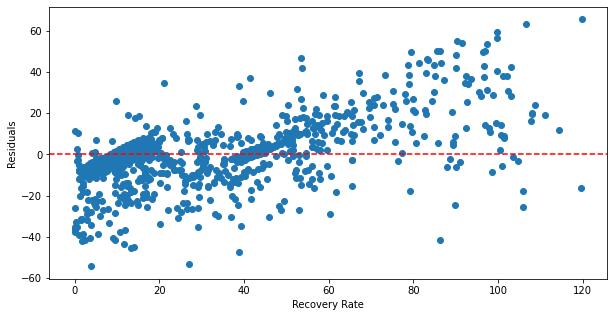

In [88]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()


In [89]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
7                                Industrials          inf
16                               Industrials          inf
0                                      const  2617.592739
18                                Financials    13.603637
12                      ActIndustryDistress1     6.577284
4         30 year conventional mortgage rate     6.169498
3   Manufacturers inventories to sales ratio     5.753140
13                      ActIndustryDistress2     4.421766
19                                    Energy     4.269926
2                    NASDAQ 100 Index return     3.572121
6                     Consumer Discretionary     3.555490
1                 CBOE DJIA Volatility Index     2.962372
5                     Communication Services     2.783003
21                                 Utilities     2.123464
10                              Equity value     2.023060
22                    Information Technology     1.934413
11            

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=42, max_depth=2, learning_rate=0.08)
reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)
RMSE_EBM, MAE_EBM = rmse_mae(y_pred, 
                            y_test.reshape(y_pred.shape), 
                            print_metrics=True, 
                            method = 'Gradient Boosting')
metrics = metrics.append({'Method': 'G. Boost.', 'RMSE': RMSE_EBM, 'MAE': MAE_EBM}, ignore_index=True)

Gradient Boosting RMSE: 28.26114656242303
Gradient Boosting MAE: 23.76069831751957


In [40]:
ebm = ExplainableBoostingRegressor(
                    max_bins=128,
                    feature_names=X.columns.to_list(),  
                    interactions=0,
                    learning_rate=0.001,
                    #binning='quantile', 
                    validation_size=0.0001,
                    early_stopping_tolerance=0.001,
                    min_samples_leaf=6, 
                    max_leaves=3)
ebm.fit(X_train, y_train)
y_pred = ebm.predict(X_test)
RMSE_EBM, MAE_EBM = rmse_mae(y_pred, 
                            y_test.reshape(y_pred.shape), 
                            print_metrics=True, 
                            method = 'Explainable Booting Machine')
metrics = metrics.append({'Method': 'EBM', 'RMSE': RMSE_EBM, 'MAE': MAE_EBM}, ignore_index=True)

Explainable Booting Machine RMSE: 37.17014440418791
Explainable Booting Machine MAE: 30.111717061737096


In [41]:
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

# Assuming you have already trained your EBM model
# ebm = ExplainableBoostingRegressor()
# ebm.fit(X_train, y_train)

# Get global explanation
global_explanation = ebm.explain_global()

# Get feature names and their corresponding importances
feature_importances = global_explanation.data()

sc=3
set_sizes(sc)
df_global_imp_ebm = get_most_important_features(ebm.feature_names, 
            feature_importances['scores'], final_cil_vars, final_cil_vars_str, filter_combined=False)
fig_feature_imp_ebm = print_global_importances(df_global_imp_ebm,
            palette,
            num_examples=15,
            plot_labels=plot_labels,
            figsize=(4*sc,3*sc))
fig_feature_imp_ebm.show()
#fig_feature_imp_ebm.savefig(f'{plot_path}/importances_ebm.pdf', bbox_inches='tight')

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

In [ ]:
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
            colsample_bytree = 0.001,
            feature_names=X.columns.to_list(), 
            learning_rate = 0.01)

In [ ]:
xgb.get_config()

{'use_rmm': False, 'verbosity': 1}

In [ ]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.001, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_names=['ActIndustryDistress1', 'ActIndustryDistress2',
                            'Senior secured', 'Senior unsecured',
                            'Senior subordinated', 'Subordinated \\& Junior',
                            'Equ...
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = xg_reg.predict(X_test) 
RMSE_XG, MAE_XG = rmse_mae(y_pred, 
                            y_test, 
                            print_metrics = True, 
                            method = '')

 RMSE: 35.863023287277066
 MAE: 29.206941037186155


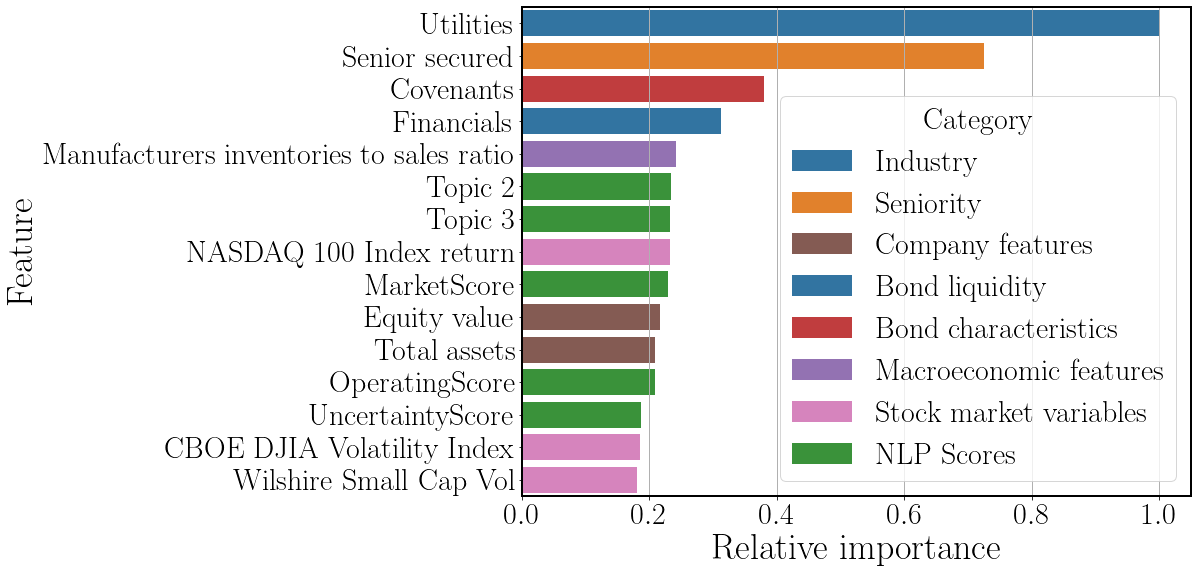

In [ ]:
sc=3
df_global_imp_xg_reg = get_most_important_features(X.columns.to_list(), 
            xg_reg.feature_importances_, final_cil_vars, final_cil_vars_str)
fig_feature_imp_xg_reg = print_global_importances(df_global_imp_xg_reg,
            palette,
            num_examples=15,
            plot_labels=plot_labels,
            figsize=(4*sc,3*sc))
fig_feature_imp_xg_reg.show()
#fig_feature_imp_xg_reg.savefig(f'{plot_path}/importances_xg_reg.pdf', bbox_inches='tight')

In [ ]:
ebm_local = ebm.explain_local(X_test, y_test)

In [ ]:
names = []
values = []
df_local = pd.DataFrame()
for x in ebm_local._internal_obj['specific']:
    error = np.sqrt((x['perf']['actual'] - x['perf']['predicted'] )** 2)
    names = x['names'].copy()
    values = x['scores'].copy()
    names.append('error')
    values.append(error)
    dictionary = dict(zip(names, values))
    dictionary = {k: v for k, v in dictionary.items() if v!=''}
    df_local = df_local.append(dictionary, ignore_index=True)

In [ ]:
local_lowest_error = df_local.sort_values('error', ignore_index=True)[:5].reset_index().drop(['index'], axis=1)
local_highest_error = df_local.sort_values('error', ignore_index=True)[-5:].reset_index().drop(['index'], axis=1)

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import torch.nn as nn

tab_net = TabNetRegressor(input_dim=len(X.columns),
                        output_dim=1,
                        n_steps=4, 
                        #cat_idxs=X.columns.to_list(),
                        optimizer_fn=torch.optim.Adam,
                        optimizer_params=dict(lr=0.02),
                        mask_type='sparsemax', # 'sparsemax'
                        verbose=10,
                        momentum = 0.8,
                        gamma=1.5
                      )

tab_net.n_d = 8
tab_net.n_a = 32

tab_net.fit(
  X_train, 
  y_train,
  batch_size=1024,
  loss_fn = nn.HuberLoss(),
  eval_set=[(X_test, y_test)],
  max_epochs=500, 
  patience=25
)

epoch 0  | loss: 33.19311| val_0_mse: 7917.87491|  0:00:00s
epoch 10 | loss: 29.78007| val_0_mse: 3274.24957|  0:00:01s
epoch 20 | loss: 23.85783| val_0_mse: 3637.70214|  0:00:03s
epoch 30 | loss: 15.07819| val_0_mse: 3134.89027|  0:00:04s

Early stopping occurred at epoch 31 with best_epoch = 6 and best_val_0_mse = 1340.93571


In [ ]:
y_pred = tab_net.predict(X_test)
RMSE_TABNET, MAE_TABNET = rmse_mae(y_pred, 
                                    y_test, 
                                    print_metrics = True, 
                                    method = '')
metrics = metrics.append({'Method': 'TabNet', 'RMSE': RMSE_TABNET, 'MAE': MAE_TABNET}, ignore_index=True)

 RMSE: 36.61878898916411
 MAE: 31.057999829846267


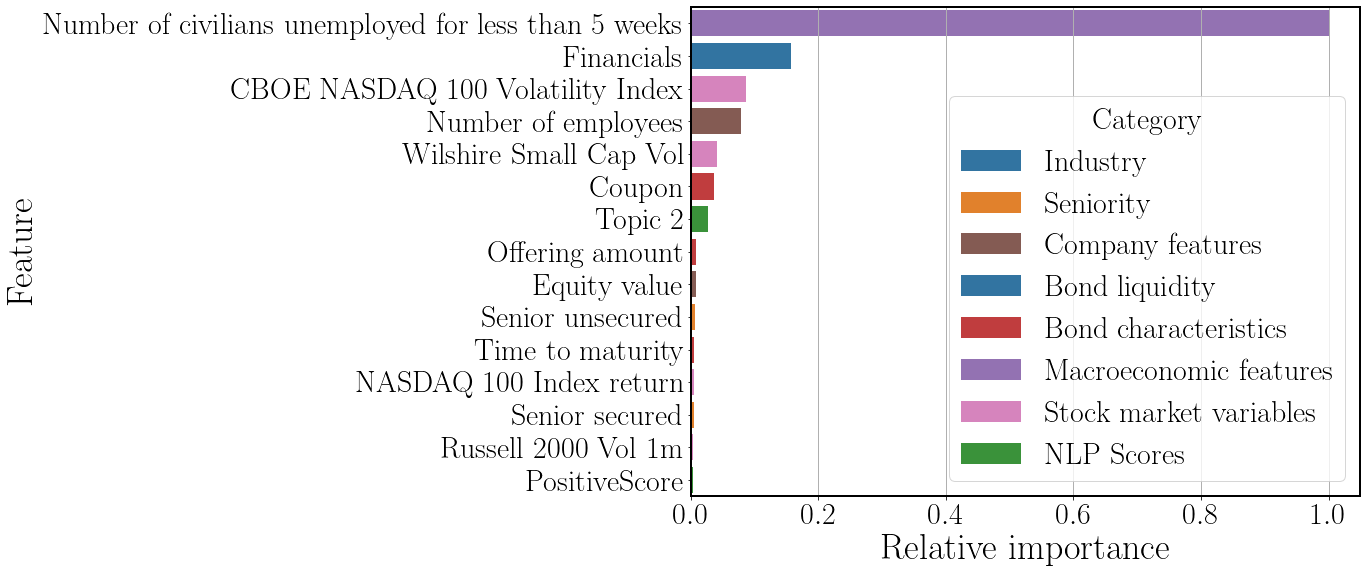

In [ ]:
set_sizes(sc)
df_global_imp_tabnet = get_most_important_features(X.columns.to_list(), 
            tab_net.feature_importances_, final_cil_vars, final_cil_vars_str)
fig_feature_imp_tabnet = print_global_importances(df_global_imp_tabnet,
            palette,
            num_examples=15,
            plot_labels=plot_labels,
            figsize=(4*sc,3*sc))


fig_feature_imp_tabnet.show()
#fig_feature_imp_tabnet.savefig(f'{plot_path}/importances_tabnet.pdf', bbox_inches='tight')

In [ ]:
pip install nam

  Using cached nam-0.0.3-py3-none-any.whl.metadata (10 kB)
  Using cached pytorch_lightning-2.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached wandb-0.17.7-py3-none-macosx_10_14_x86_64.whl.metadata (10 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' i